# Top Trendings do Twitter
**Objetivos:** Desenvolver uma aplica√ß√£o para monitorar o top trending e seu devido volume na rede social com o passar do tempo.

## Funcionalidades
**Requisitos funcionais obrigatorios**:
- [X] Utilizar a api do twitter para consumir o top trending e seu devido volume.
- [X] Armazenar o hist√≥rico das trendings em um banco de dados noSQL.
- [X] Utilizar alguma biblioteca gr√°fica para exibir os dados.

**Requisito funcional opcional**:
- [X] Utilizar IA para an√°lise de sentimento dos tweets referentes aos top trendings

### Insta√ß√£o das Bibliotecas
Para instalar as bibliotecas, ser√° usado um arquivo de texto com todas as depend√™ncias necessarias para este projeto funcionar.

In [1]:
! python -m pip install -r requirements.txt

### Imports

In [2]:
import json
import pprint

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from modules import mongoDb
from modules import fileToDic as fd
from modules import apiKeys as api
from modules import mongoEnv
from modules import TwitterClient as tc

## Funcionalidade 1: Consome o top trending e seu devido volume.

1. Abrir o arquivo `WOEID.txt` para poder ler os paises e seu identificadores.
2. Usando a fun√ß√£o `dictionary` que esta no arquivo `fileToDic`, o arquivo com os paises e seus respectivos valores ser√£o convertidos em dicionario.
3. Usando o dicionario `key` que est√° no arquivo `apiKeys`, o valor do `BEARER_TOKEN` no arquivo `.env` ser√° atribuido a varivel `bearer_token`. O Bearer Token ser√° usado na autentica√ß√£o da url que retorna os *trends* de um determinado pais.
4. Para buscar o trending de um determinado pais iremos usar a url: https://api.twitter.com/1.1/trends/place.json
5. Entretanto, devemos passar o parametro que no caso √© o id de um pais.

Fonte: https://developer.twitter.com/en/docs/twitter-api/v1/trends/trends-for-location/api-reference/get-trends-place

In [12]:
countries = {}
file = open("input/WOEID.txt")
countries = fd.dictionary(file, countries)

bearer_token = api.key['bearer_token']

search_url = "https://api.twitter.com/1.1/trends/place.json"

query_params = {'id': countries['BRAZIL'], 'exclude': 'hashtags'}

Est√° fun√ß√£o usa o *bearer token* para poder realizar a autentica√ß√£o, por mais que n√£o ir√° logar no **twitter** o *bearer token* "representa uma autoriza√ß√£o do Server emitida para o client. Por sua vez, o client deve possuir mecanismos pr√≥prios para identificar e validar o Token".

Fonte: [Bruno Brito](https://www.brunobrito.net.br/jwt-cookies-oauth-bearer/).

In [13]:
def bearer_oauth(r):
  '''
  Autentica√ß√£o usando o bearer token
  '''
  r.headers["Authorization"] = f"Bearer {bearer_token}"
  r.headers["User-Agent"] = "v2RecentSearchPython"

  return r

Usando a url e o parametros necessario, a fun√ß√£o abaixo retorna um *response* no formato **json**. Veja onde a fun√ß√£o `bearer_oauth` ser√° usada.

Fonte: https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/Recent-Search/recent_search.py

In [14]:
def connect_to_endpoint(url, params):
  '''
  Se conecta a url dada com o parametros dado.
  Consultar a documenta√ß√£o para saber o parametros nessario na pesquisa
  '''
  response = requests.get(url, auth=bearer_oauth, params=params)
  print(response.status_code)
  if response.status_code != 200:
    raise Exception(response.status_code, response.text)
        
  return response.json()

## Funcionalidade 2: Persistir os dados

1. criar conex√£o com o banco, neste projeto usando o MongoDb
2. Criar um banco chamado `tweets_db`
3. Criar uma cole√ß√£o chamada `top_trends`
4. Inserir a *response* nesta cole√ß√£o

Fonte: https://pymongo.readthedocs.io/en/stable/tutorial.html

### Variaveis de Ambiente

In [15]:
username = mongoEnv.key_mongo['mongo_username']
pwd = mongoEnv.key_mongo['mongo_password']

### Conex√£o com banco de dados

In [16]:
mongo_client = mongoDb.connect_to_mongo(username, pwd, '27017')

### Cria√ß√£o do Banco de Dados e a Cole√ß√£o

In [17]:
database = mongoDb.create_db(mongo_client, 'tweets_db')
collection = database['top_trends']

### Conectando ao Endpoint da Twitter API

In [18]:
top_trends = connect_to_endpoint(search_url, query_params)

200


### Persistindo os dados encontrado no Json
Aqui eu decidi fazer um for para inserir um de cada vez, por√©m eu observei que s√≥ foi criado um unico documento, sendo que os top trendings √© uma lista com os 50 top trendings da data atual.

In [19]:
for trend in top_trends:
    trend_id = collection.insert_one(trend).inserted_id

### Procurando e Printando o primeiro documento

In [20]:
pprint.pprint(collection.find_one())

{'_id': ObjectId('6147193c5b64b01e186febf6'),
 'as_of': '2021-09-19T11:04:28Z',
 'created_at': '2021-09-15T02:00:22Z',
 'locations': [{'name': 'Brazil', 'woeid': 23424768}],
 'trends': [{'name': '#Calamidade',
             'promoted_content': None,
             'query': '%23Calamidade',
             'tweet_volume': 286336,
             'url': 'http://twitter.com/search?q=%23Calamidade'},
            {'name': 'Otis',
             'promoted_content': None,
             'query': 'Otis',
             'tweet_volume': 59009,
             'url': 'http://twitter.com/search?q=Otis'},
            {'name': 'Paulo Freire',
             'promoted_content': None,
             'query': '%22Paulo+Freire%22',
             'tweet_volume': 43627,
             'url': 'http://twitter.com/search?q=%22Paulo+Freire%22'},
            {'name': 'juliette no altas horas',
             'promoted_content': None,
             'query': '%22juliette+no+altas+horas%22',
             'tweet_volume': 84069,
             

             'url': 'http://twitter.com/search?q=Khai'}]}


### Printando o nome da cole√ß√£o criada no banco de dados

In [21]:
database.list_collection_names()

['top_trends']

## Funcionalidade 3: Visualizando os Dados

1. Extrair as trends de um determinado pais. 
2. Tratar dos campos NaN.
2. Usar a biblioteca pandas para criar um Dataframe dos *trends*
3. Usar a biblioteca pandas para visualizar os dados em um gr√°fico
4. Usar a biblioteca matplot para visualizar os dados em um gr√°fico 

Fontes: [Analise Exploratoria - Projeto DIO](https://github.com/LeiteSS/analise_exploratoria); [Plot With Pandas: Python Data Visualization for Beginners](https://realpython.com/pandas-plot-python/); [Return Json List And Python Requests Library](https://stackoverflow.com/questions/51458509/return-json-list-and-python-requests-library); [How to Increase Image Size of Pandas Dataframe plot in Jupyter Notebook](https://stackoverflow.com/questions/51174691/how-to-increase-image-size-of-pandas-dataframe-plot-in-jupyter-notebook) 

### Extrai as Trends

In [22]:
trends = []
for item in top_trends:
    trends = item['trends']

### Dataframe com as Trends

In [23]:
df = pd.DataFrame(trends)

#### Comandos Importantes
Deixei anexados aqui alguns comando que foram usados depois de ter convertido a lista em Dataframe.
```py
df.head() # retorna as primeiras 5 linhas (por padr√£o) de um dataframe

df.shape # retorna a quantidade de linha e a quantidade de colunas de um dataframe

df.dtypes # retorna o tipo de cada coluna
```

### Mudando os Nomes dos Campos

In [24]:
df_trends = df.rename(
    columns={
        'name': 'Nome', 
        'url': 'URI', 
        'promoted_content': 'Patrocinado', 
        'query': 'Hashtag', 
        'tweet_volume': 'Volume'
    }
)

### Preenche os valores *Not A Number* com Zeros

In [25]:
df_trends["Volume"].fillna(0, inplace=True)

### Agrupando os nomes com o volume de tweets
Este projeto ir√° apresentar o volume de tweets usando uma determinado nome que uma determinada hashtag tem.

In [26]:
# Qual o volume de tweet usando o nome como indicador
df_trends.groupby("Nome")["Volume"].mean()

Nome
2 MESES DE FRAN√áA          0.0
Barney                     0.0
Boquetinho                 0.0
Brock                      0.0
Calleri                    0.0
Chelsea               290064.0
Cruzeiro               32473.0
Di Maria               15344.0
Esse PSG                   0.0
F√°bio                  28170.0
Galeano                    0.0
Hakimi                 11143.0
Igor Vinicius              0.0
Ilhas Can√°rias         16994.0
Jab√°                       0.0
Jets                   71341.0
Khai                   30963.0
Luis Gustavo           16027.0
Lyon                   52459.0
Marco Ant√¥nio              0.0
Marquinhos Gabriel         0.0
Matheus Pereira            0.0
Messi                 207311.0
Morato                     0.0
M√°rio Fofoca               0.0
Nen√™                  280394.0
Nestor                 12028.0
Paquetop                   0.0
Paquet√°                21103.0
Paulo Freire          159919.0
Perd√£o                 14417.0
Pochettino             22

### Tra√ßando os Gr√°ficos

Text(0.5, 1.0, 'Top Trendings do Twitter')

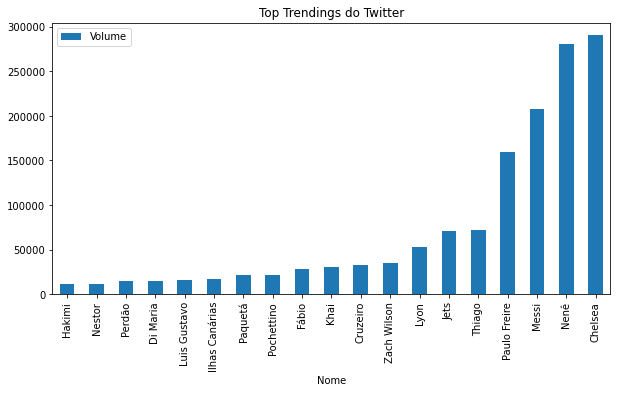

In [27]:
# Volume acima de 0
top = df_trends[df_trends["Volume"] > 0].sort_values("Volume")
top.plot(x="Nome", y=["Volume"], kind="bar", figsize=(10,5))
plt.title('Top Trendings do Twitter')

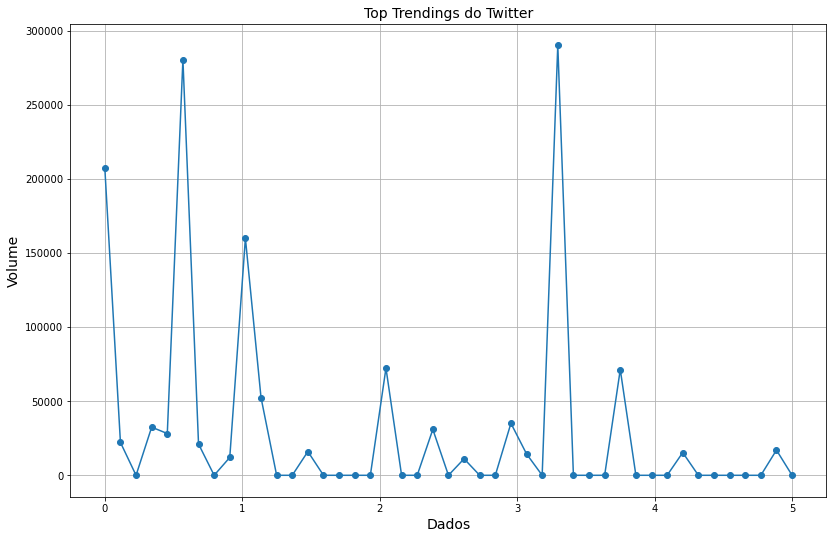

In [29]:
x = np.linspace(0.0, 5.0, 45)
fig, ax = plt.subplots(figsize=(15, 9))
fig.subplots_adjust(bottom=0.15, left=0.2)
plt.plot(x, df_trends["Volume"], marker='o')
plt.title('Top Trendings do Twitter', fontsize=14)
plt.xlabel('Dados', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.grid(True)
plt.show()

<AxesSubplot:xlabel='Nome'>

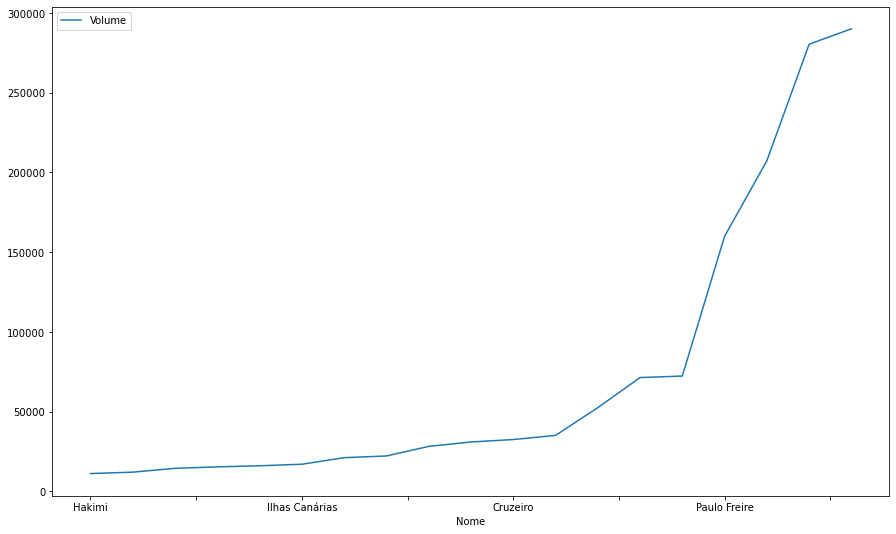

In [30]:
top = df_trends[df_trends["Volume"] > 0].sort_values("Volume")
top.plot(x="Nome", y="Volume", kind='line', figsize=(15,9))

## Funcionalidade 4: An√°lise de Sentimento
1. Usar o tweepy para obter os tweets.
2. Usar o textblob para analisar os tweets, afim de encontrar sentimentos.
3. Usar a lista de trends obtida na funcionalidade tr√™s para servir como param√™tro na fun√ß√£o que obtem os tweets.

### Twitter Client

In [31]:
twitter_client = tc.TwitterClient()

### An√°lise Usando o Dataframe
Para ser realizado a an√°lise de sentimento nos tweets, o la√ßo `for` e a fun√ß√£o `iterrows()` do `Dataframe` permite percorrer as linhas do `Dataframe` e atrav√©s disso, selecionar uma coluna, neste caso a coluna `Nome`, mas pode ser tamb√©m a coluna `Hashtag` pois no `json` obtido da *request* feita na **Twitter Api** essa coluna se chamava `query`. Pois bem, todos os tweets pegos usando a `query` escolhida s√£o guardadas em uma lista para serem analisadas usando a biblioteca Textblob, se h√° sentimentos positivos, neutros ou negativos. Descorberto, os sentimentos √© feito o calculo para descobrir a porcentagem de tweets que esse sentimento possui.

Al√©m de claro, retornar os tweets ao final.

In [32]:
for index, row in df_trends.iterrows():
    print("O que est√° sendo comentado no top trendings: " + row['Nome'])
    tweets = twitter_client.get_tweets(query = row['Hashtag'], count = 200)
    
    positive_tweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positivo']
    
    print("Porcentagem de tweets positivos: {} %".format(100*len(positive_tweets)/len(tweets)))
    
    negatives_tweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negativo']
    
    print("Porcentagem de tweets negativos: {} %".format(100*len(negatives_tweets)/len(tweets)))
    
    print("Porcentagem de tweets neutros: {} % \
        ".format(100*(len(tweets) -(len( negatives_tweets )+len( positive_tweets)))/len(tweets)))
    
    print("\n\nTweets positivos:")
    for tweet in positive_tweets[:10]:
        print(tweet['text'])
        
    print("\n\nTweets negativos:")
    for tweet in negatives_tweets[:10]:
        print(tweet['text'])
    print("------------------------------------{}-----------------------------------------------------".format(row["Nome"]))

O que est√° sendo comentado no top trendings: Messi
Porcentagem de tweets positivos: 12.222222222222221 %
Porcentagem de tweets negativos: 8.88888888888889 %
Porcentagem de tweets neutros: 78.88888888888889 %         


Tweets positivos:
@CrewsMat10 Holy shit everyone was right, Messi really can‚Äôt do in any other league let alone Uber eats (6th best in Europe)
RT @AmineMaTue: Ouuuffff la r√©action de Messi
@AEdionwele @EdmundOris Messi is struggling in that team make we no lie. He'll come good tho
How does Messi get the blame for the draw? This PSG team should easily be scoring 5 past Lyon with or without Messi.
@MFFooty He wasn‚Äôt happy, that didn‚Äôt look planned 

I don‚Äôt care what the situation is, you don‚Äôt take Messi off at 1-1
RT @Letter_to_Jack: yOu wOnT sUbsTitUtE mEsSi wiTh yOuR tEaM... 

*5 days later* 

Dem comot the werey. 

Lmao. https://t.co/oN5bRiX2HS
Ai kijk liever hoe real verliest dan psg zonder messi hor
RT @Djaameel56: Messi qui refuse de serrer la main √† P

Porcentagem de tweets positivos: 3.409090909090909 %
Porcentagem de tweets negativos: 3.409090909090909 %
Porcentagem de tweets neutros: 93.18181818181819 %         


Tweets positivos:
RT @Umbarbudotrico1: Como joga Rodrigo Nestor.

Deve ser dif√≠cil ser hater do cara, fazendo muito bem a fun√ß√£o de armador. https://t.co/SA8‚Ä¶
Nestor √© muito bom jogador, mas em jogo grande ainda sente o peso normal de ainda ser um ‚Äúmenino‚Äù aos poucos vai se‚Ä¶ https://t.co/1hTVGcLS4H
RT @duzin_01: Luan faz seu segundo bom jogo desde a les√£o. O primeiro foi a ida contra o Palmeiras. Se mantiver esse nivel - que √© o normal‚Ä¶


Tweets negativos:
RT @gabrielfuh_: Falei a base toda e repito no profissional: Nestor √© um baita meia de arma√ß√£o. Partida √≥tima dele hoje mais avan√ßado.
2 - Rodrigo N√©stor has had a hand in the same number of goals in the game against Atl√©tico Goianiense (two assists)‚Ä¶ https://t.co/nwaLqjfw7q
Falei a base toda e repito no profissional: Nestor √© um baita meia de

Porcentagem de tweets positivos: 4.25531914893617 %
Porcentagem de tweets negativos: 1.0638297872340425 %
Porcentagem de tweets neutros: 94.68085106382979 %         


Tweets positivos:
@thicaires @Cruzeiro mama a minha, primeiro jogo de titular do Marco Ant√¥nio, vc merece Henrique e Ariel Cabral, se‚Ä¶ https://t.co/2zVy8J8dvB
TIROU O MARCO ANT√îNIO HAHAHAHAHA
Escolheu o pior jogo pra entrar com o Marco Ant√¥nio de titular. Com a responsabilidade de marcar o time do Diniz ai‚Ä¶ https://t.co/7PBICXLNtg
Marco Ant√¥nio titular entrou em campo dormiu e dormiu acordou achou uma assist√™ncia pro Thiago e voltou a dormir at‚Ä¶ https://t.co/K4qoznYSVi


Tweets negativos:
@LaPosta_Ecu @jeffsanguna Ahora cualquier mediocre es columnista de opini√≥n , periodismo degradado a cero en mi pa√≠‚Ä¶ https://t.co/DjNBB7PVwk
------------------------------------Marco Ant√¥nio-----------------------------------------------------
O que est√° sendo comentado no top trendings: Vav√°
Porcentagem de tweets posi

Porcentagem de tweets positivos: 12.195121951219512 %
Porcentagem de tweets negativos: 0.0 %
Porcentagem de tweets neutros: 87.8048780487805 %         


Tweets positivos:
@JMTL4NTIC perd√£o por eu ser t√£o legal
@JMTL4NTIC Perd√£o por eu ser t√£o legal
@JMTL4NTIC Perd√£o por eu ser t√£o chata

Kkkkk real
perd√£o por eu ser t√£o legal https://t.co/8BgqQfwbeN
@mmariiguimaraes Vc tb √© gente bixo besta üòÇüòÇ

√â normal brigar, ter discuss√µes,  pq somos humanos e somos falhos

S√≥‚Ä¶ https://t.co/XJHJ89o67k
perd√£o por eu ser t√£o insu     so true https://t.co/SSCSzM9ru1
gmrofivoisfkgdm,re tenho q parar de tweetar esses pensamentos de merda na conta de lol perdao seguidores
perd√£o por eu ser t√£o gay https://t.co/R9Jk3lCDGT
perd√£o por ser t√£o popular https://t.co/WYH7rPFGRs
perd√£o por ser t√£o gay ?????? https://t.co/uX8RdHa4qk


Tweets negativos:
------------------------------------Perd√£o-----------------------------------------------------
O que est√° sendo comentado no top tre

Porcentagem de tweets positivos: 0.0 %
Porcentagem de tweets negativos: 0.0 %
Porcentagem de tweets neutros: 100.0 %         


Tweets positivos:


Tweets negativos:
------------------------------------Paquetop-----------------------------------------------------
O que est√° sendo comentado no top trendings: Boquetinho
Porcentagem de tweets positivos: 0.0 %
Porcentagem de tweets negativos: 0.0 %
Porcentagem de tweets neutros: 100.0 %         


Tweets positivos:


Tweets negativos:
------------------------------------Boquetinho-----------------------------------------------------
O que est√° sendo comentado no top trendings: Sandro Meira Ricci
Porcentagem de tweets positivos: 0.0 %
Porcentagem de tweets negativos: 0.0 %
Porcentagem de tweets neutros: 100.0 %         


Tweets positivos:


Tweets negativos:
------------------------------------Sandro Meira Ricci-----------------------------------------------------
O que est√° sendo comentado no top trendings: Di Maria
Porcentagem de twee